# VAE bac à sable

source : https://hunterheidenreich.com/posts/modern-variational-autoencoder-in-pytorch/

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from dataclasses import dataclass

import torch


@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.
    
    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor
    
    loss: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor

In [35]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.
    
    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
    """
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 4, hidden_dim // 8),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 8, 2 * latent_dim), # 2 for mean and variance.
        )
        self.softplus = nn.Softplus()
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 8),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 8, hidden_dim // 4),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )
        
    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.
        
        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.
        
        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        
        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        
    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.
        
        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.

        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()
    
    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.
        
        Args:
            z (torch.Tensor): Data in the latent space.
        
        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        return self.decoder(z)
    
    def forward(self, x, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.
        
        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.
        
        Returns:
            VAEOutput: VAE output dataclass.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)
        
        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon=None,
                loss_kl=None,
            )
        
        # compute loss terms 
        loss_recon = F.binary_cross_entropy(recon_x, x, reduction='none').sum(-1).mean()
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()
                
        loss = loss_recon + loss_kl
        
        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )

In [36]:
# data processing, CSV & image file I/O
import os
import re
import requests
from PIL import Image
import pandas as pd
import numpy as np

In [37]:
os.getcwd()

'/home/franzele/Desktop/univ_lille/m1s2/rd/RD_project'

In [38]:
import cv2

In [39]:
512/64

8.0

In [40]:
data = pd.DataFrame([cv2.cvtColor(cv2.resize(cv2.imread(f"cat/{path}"), (64, 64)), cv2.COLOR_BGR2GRAY).flatten() for path in os.listdir("cat")])

In [41]:
data

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,211,193,185,183,200,199,200,177,177,199,...,133,155,133,137,118,96,104,120,150,158
1,166,169,178,153,98,102,103,113,125,123,...,99,112,112,101,100,110,127,109,106,108
2,90,18,12,13,14,18,24,21,28,57,...,227,222,221,222,228,228,220,215,211,215
3,32,33,32,33,29,27,21,22,17,14,...,145,135,126,115,148,132,113,116,101,67
4,179,193,186,192,150,163,179,178,162,158,...,104,85,79,52,39,35,31,30,28,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5648,172,163,145,127,142,167,183,191,187,56,...,36,58,78,100,94,99,43,64,33,57
5649,139,139,140,139,137,135,140,99,59,76,...,87,92,80,84,87,80,71,63,74,77
5650,72,72,73,71,74,74,72,73,71,76,...,204,216,225,200,137,69,36,17,24,28
5651,60,62,63,63,64,70,105,109,75,65,...,133,128,122,119,120,124,125,126,121,125


In [42]:
64*64

4096

In [43]:
import matplotlib.pyplot as plt
from datetime import datetime

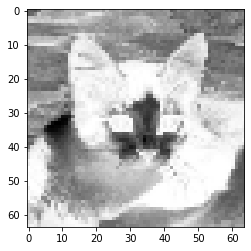

In [44]:
plt.imshow(np.array(data.iloc[1, :]).reshape((64, 64)), cmap="Greys")

In [45]:
from torch.utils.tensorboard import SummaryWriter

In [46]:
lr = 1e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
hidden_dim = 512
batch_size = 1

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(input_dim=4096, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)

In [48]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
writer = SummaryWriter(f'runs/mnist/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

In [49]:
from tqdm import tqdm

In [50]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Trains the model on the given data.
    
    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode
    
    for batch_idx, data in enumerate(tqdm(dataloader)):
        target = np.zeros(data.shape[0])
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        output = model(data)  # Forward pass
        loss = output.loss
        
        loss.backward()
        
        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', output.loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', output.loss_kl.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  # Update the model parameters
        
    return prev_updates + len(dataloader)

In [51]:
def test(model, dataloader, cur_step, writer=None):
    """
    Tests the model on the given data.
    
    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    
    with torch.no_grad():
        for data in tqdm(dataloader, desc='Testing'):
            target = np.zeros(data.shape[0])            
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data
            
            output = model(data, compute_loss=True)  # Forward pass
            
            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()
            
    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', output.loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', output.loss_kl.item(), global_step=cur_step)
        
        # Log reconstructions
        writer.add_images('Test/Reconstructions', output.x_recon.view(-1, 1, 64, 64), global_step=cur_step)
        writer.add_images('Test/Originals', data.view(-1, 1, 64, 64), global_step=cur_step)
        
        # Log random samples from the latent space
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decode(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 64, 64), global_step=cur_step)

In [52]:
train_loader = torch.utils.data.DataLoader(
    data.to_numpy(dtype=np.float32), 
    batch_size=batch_size, 
    shuffle=True,
)

In [53]:
test_loader = torch.utils.data.DataLoader(
    data.to_numpy(dtype=np.float32), 
    batch_size=batch_size, 
    shuffle=False,
)

In [54]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/50


  0%|          | 0/5653 [00:00<?, ?it/s]


RuntimeError: all elements of target should be between 0 and 1

In [56]:
data.to_csv("chat.csv")